In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import scipy.optimize as opt
from scipy.integrate import quad
import yfinance as yf

### Q1.a

We consider a continuously monitored corridor variance swap:

$$
X = \frac{1}{T} \int_0^T 1_{(L,U)}(S_t) v_t \, dt - H,
$$

where the realized variance accumulates only when the underlying price $S_t$ lies within the corridor $(L,U)$. The underlying follows

$$
\frac{dS_t}{S_t} = \mu \, dt + \sqrt{v_t} \, dW_t, \quad r = 0.
$$

Using Itô’s formula

Let $g(x)$ be defined as

$$
g(x) = \frac{2}{T}\Big(\Big[\frac{1}{U} - \frac{1}{L}\Big]x - \log\frac{L}{U}\Big) 1_{[0,L]}(x)
+ \frac{2}{T}\Big(\frac{x}{U} - 1 - \log\frac{x}{U}\Big) 1_{(L,U)}(x),
$$

so that

$$
g'(x) = \frac{2}{T}\Big(\frac{1}{U} - \frac{1}{L}\Big)1_{[0,L]}(x) 
+ \frac{2}{T}\Big(\frac{1}{U} - \frac{1}{x}\Big)1_{(L,U)}(x),
$$

and

$$
g''(x) = \frac{2}{T} \frac{1}{x^2} 1_{(L,U)}(x).
$$

Applying Itô’s lemma to $g(S_t)$ gives

$$
dg(S_t) = g'(S_t) S_t \mu \, dt + g'(S_t) S_t \sqrt{v_t} \, dW_t 
+ \frac{1}{2} g''(S_t) S_t^2 v_t \, dt.
$$

Since $\frac{1}{2} g''(S_t) S_t^2 = \frac{1}{T} 1_{(L,U)}(S_t)$, we have

$$
\frac{1}{T} \int_0^T 1_{(L,U)}(S_t) v_t \, dt 
= g(S_T) - g(S_0) - \int_0^T g'(S_t) S_t \mu \, dt 
- \int_0^T g'(S_t) S_t \sqrt{v_t} \, dW_t.
$$

Therefore,

$$
X = g(S_T) - g(S_0) - \int_0^T g'(S_t) S_t \mu \, dt
- \int_0^T g'(S_t) S_t \sqrt{v_t} \, dW_t - H.
$$

### Q1.b


Using the representation from part (a), the payoff can be written as

$$
X = \frac{1}{T} \int_0^T 1_{(L,U)}(S_t) v_t \, dt - H
   = g(S_T) - g(S_0)
   - \int_0^T g'(S_t) S_t \, r \, dt
   - \int_0^T g'(S_t) S_t \sqrt{v_t} \, dW_t - H. \tag{1}
$$

Each of these terms can be replicated with appropriate hedging strategies.


#### Step 1. Static replication of $g(S_T)$

By the Carr–Madan theorem, for any fixed $a \ge 0$,

$$
g(S_T) = g(a) + g'(a)(S_T - a)
+ \int_0^a g''(K)(K - S_T)^+ dK
+ \int_a^{\infty} g''(K)(S_T - K)^+ dK.
$$

This decomposition corresponds to the following positions:

- **Risk-free asset:** worth $e^{-rT}[\, g(a) - g'(a)a \,]$  
- **Risky asset:** hold $g'(a)$ shares of $S_t$
- **Option strip:**  
  - Infinite strip of **European puts** for $K \in [L, a]$, weighted by $g''(K) = \frac{2}{T K^2} 1_{(L,U)}(K)$  
  - Infinite strip of **European calls** for $K \in [a, U]$, weighted by $g''(K) = \frac{2}{T K^2} 1_{(L,U)}(K)$  

This static portfolio replicates $g(S_T)$ at time $T$.


#### Step 2. Replication of constant terms

The second and fifth terms in (1), $-g(S_0)$ and $-H$, are constants.  
They can be replicated by a static **position in the risk-free asset** worth

$$
- e^{-rT} [\, g(S_0) + H \,].
$$


#### Step 3. Replication of the drift term

The third term in (1) is

$$
-\int_0^T g'(S_t) S_t r \, dt.
$$

To replicate it, consider a strategy that **continuously invests in a put** expiring at time $t \le T$ with strike $K$, and reinvests its payoff into the risk-free asset.  
This rolling strategy’s value at time $T$ is $e^{r(T-t)}(K - S_t)^+$.  
We have

$$
- g'(S_t) S_t r = \frac{2r}{T}
\Big( \frac{1}{U}(U - S_t)^+ - \frac{1}{L}(L - S_t)^+ \Big).
$$

Thus, the drift term is replicated by holding **two infinite strips of puts** across expiration times $t \in [0, T]$:

- **Long put** with strike $U$, amount $\frac{2r}{T U} e^{-r(T-t)}$  
- **Short put** with strike $L$, amount $\frac{2r}{T L} e^{-r(T-t)}$

As each put expires, its proceeds are reinvested in the risk-free asset.  
At time $T$, the combined value equals

$$
\int_0^T \frac{2r}{T} \Big( \frac{1}{U}(U - S_t)^+ - \frac{1}{L}(L - S_t)^+ \Big) dt
= - \int_0^T g'(S_t) S_t r \, dt,
$$

exactly reproducing the third term in (1).


#### Step 4. Replication of the stochastic integral term

For the last term in (1),

$$
- \int_0^T g'(S_t) S_t \sqrt{v_t} \, dW_t,
$$

define the process

$$
V_t = - e^{-r(T-t)} \int_0^t g'(S_s) S_s \sqrt{v_s} \, dW_s.
$$

Applying Itô’s lemma and substituting $S_t \sqrt{v_t} \, dW_t = dS_t - r S_t \, dt$, we find

$$
dV_t = r V_t \, dt
- e^{-r(T-t)} g'(S_t) S_t \sqrt{v_t} \, dW_t
= (V_t + e^{-r(T-t)} g'(S_t) S_t) r \, dt
- e^{-r(T-t)} g'(S_t) \, dS_t.
$$

This shows that $V_t$ corresponds to a **dynamic, self-financing strategy** that holds:

- $-e^{-r(T-t)} g'(S_t)$ shares of the risky asset, and  
- the remainder $V_t + e^{-r(T-t)} g'(S_t) S_t$ in the risk-free account.

At maturity,

$$
V_T = - e^{-r(T-T)} \int_0^T g'(S_s) S_s \sqrt{v_s} \, dW_s
= - \int_0^T g'(S_t) S_t \sqrt{v_t} \, dW_t,
$$

replicating the stochastic integral term.


#### Step 5. Summary

| Term | Expression | Replication Method |
|------|-------------|-------------------|
| (1) $g(S_T)$ | Static combination of cash, stock, puts ($K\in[L,a]$), calls ($K\in[a,U]$) | Carr–Madan static replication |
| (2) $-g(S_0)-H$ | Constant | Risk-free asset worth $-e^{-rT}[g(S_0)+H]$ |
| (3) $-\int_0^T g'(S_t)S_t r dt$ | Drift term | Two strips of rolling puts at strikes $L,U$ |
| (4) $-\int_0^T g'(S_t)S_t\sqrt{v_t}\,dW_t$ | Stochastic term | Dynamic self-financing strategy with $-e^{-r(T-t)}g'(S_t)$ shares |
| (5) Discounting | Included | All payoffs discounted by $e^{-r(T-t)}$ |


**Final replicated payoff:**

$$
X = g(S_T) - g(S_0)
- \int_0^T g'(S_t) S_t r \, dt
- \int_0^T g'(S_t) S_t \sqrt{v_t} \, dW_t - H,
$$

and the constructed portfolio (static + dynamic) replicates every term of $X$,  
thus fully replicating the **corridor variance swap**.


### Q1.c

Let $$P(t,K)=\mathbb E^Q\!\big[e^{-r(T-t)}(K-S_T)^+\,\big|\,\mathcal F_t\big]$$ and $$C(t,K)=\mathbb E^Q\!\big[e^{-r(T-t)}(S_T-K)^+\,\big|\,\mathcal F_t\big]$$.  
From Q1.a we have, under $Q$,

$$ \mathbb E^Q\!\left[\frac{1}{T}\int_{0}^{T}1_{(L,U)}(S_t)\,v_t\,dt\right]
= \mathbb E^Q[g(S_T)] - g(S_0) - \mathbb E^Q\!\left[\int_0^T g'(S_t)S_t\,r\,dt\right]. $$

**First term.** 

Apply Carr–Madan to $g(S_T)$ and choose $a=U$ (note $g=g'=g''=0$ for $x\ge U$):

$$ \mathbb E^Q[g(S_T)]
= \frac{2e^{rT}}{T}\int_{L}^{U}\frac{P(T,K)}{K^{2}}\,dK. $$

**Drift term.** 

Using the put-rolling argument,

$$ -\mathbb E^Q\!\left[\int_0^T g'(S_t)S_t\,r\,dt\right]
= \frac{2r}{T}\int_{0}^{T} e^{rt}\!\left(\frac{1}{U}P(t,U)-\frac{1}{L}P(t,L)\right)dt. $$

Combining the pieces and imposing $\mathbb E^Q[X]=0$ gives the fair strike $H^*$:

$$ \boxed{\, 
H^* \;=\; \mathbb E^Q\!\left[\frac{1}{T}\int_{0}^{T}1_{(L,U)}(S_t)\,v_t\,dt\right]
\;=\; \frac{2}{T}\!\left( e^{rT}\!\int_{L}^{U}\frac{P(T,K)}{K^{2}}\,dK
\;+\; r\!\int_{0}^{T}\! e^{rt}\!\left(\frac{1}{U}P(t,U)-\frac{1}{L}P(t,L)\right)dt \right) - g(S_0) \, } $$


### Q2.a - Code

In [6]:
# =====================================================
# Helper functions
# =====================================================

def estimateDiscountFactor(df_exp):
    """Estimate discount factor D using put–call parity regression."""
    avgK = df_exp['Strike Price'].mean()
    avgDiff = (df_exp['Call Premium'] - df_exp['Put Premium']).mean()
    avgK2 = (df_exp['Strike Price'] ** 2).mean()
    avgKDiff = (df_exp['Strike Price'] * (df_exp['Call Premium'] - df_exp['Put Premium'])).mean()
    return (avgKDiff - avgK * avgDiff) / (avgK ** 2 - avgK2)

def estimateForwardPrice(df_exp):
    """Estimate forward price F from the same regression system."""
    avgK = df_exp['Strike Price'].mean()
    avgDiff = (df_exp['Call Premium'] - df_exp['Put Premium']).mean()
    avgK2 = (df_exp['Strike Price'] ** 2).mean()
    avgKDiff = (df_exp['Strike Price'] * (df_exp['Call Premium'] - df_exp['Put Premium'])).mean()
    return (avgK * avgKDiff - avgK2 * avgDiff) / (avgKDiff - avgK * avgDiff)


# =====================================================
# Black–Scholes (for implied vol)
# =====================================================

def black_call(F, K, T, sigma, D):
    """Black (1976) call price with discount factor D."""
    if sigma <= 0:
        return max(D * (F - K), 0.0)
    st = sigma * np.sqrt(T)
    d1 = np.log(F / K) / st + 0.5 * st
    d2 = d1 - st
    return D * (F * norm.cdf(d1) - K * norm.cdf(d2))


# =====================================================
# Variance Swap Replication (Carr–Madan style)
# =====================================================

def computeVarianceStrike(df_exp, F, D, T):
    """
    Compute break-even variance strike using replication formula:
    K_var = (2 / (T * D)) * [∫ P(K)/K² dK (K<F) + ∫ C(K)/K² dK (K≥F)]
    """
    df_exp = df_exp.sort_values('Strike Price').copy()
    K = df_exp['Strike Price'].values
    call = df_exp['Call Premium'].values
    put = df_exp['Put Premium'].values

    # Integrand: use puts for K<F, calls for K≥F
    integrand = np.where(K < F, put / K**2, call / K**2)
    integral = np.trapz(integrand, K)

    return (2.0 / (T * D)) * integral


# =====================================================
# Heston model (for later fitting)
# =====================================================

def hestonVarianceStrike(T, v0, v_bar, lam):
    """Analytic Heston break-even variance: mean reversion of v_t."""
    if lam * T < 1e-10:
        return v0
    weight = (1 - np.exp(-lam * T)) / (lam * T)
    return v_bar + weight * (v0 - v_bar)

def modelVarianceStrikeObjective(params, T_values, K_var_obs):
    """Sum of squared errors between model and market strikes."""
    v0, v_bar, lam = params
    if v0 <= 0 or v_bar <= 0 or lam <= 0:
        return 1e10
    K_model = np.array([hestonVarianceStrike(T, v0, v_bar, lam) for T in T_values])
    return np.sum((K_model - K_var_obs) ** 2)


# =====================================================
# Main computation
# =====================================================

df = pd.read_csv('Midprices.csv')
df = df[df['As of Date'] == '8/7/2024'].copy()
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])

results = []

for expiry in sorted(df['Expiration Date'].unique()):
    df_exp = df[df['Expiration Date'] == expiry].copy()
    if len(df_exp) < 10:
        continue

    T = df_exp['Time to Expiration'].iloc[0]
    if T <= 1e-3:
        continue

    D = estimateDiscountFactor(df_exp)
    F = estimateForwardPrice(df_exp)

    K_var = computeVarianceStrike(df_exp, F, D, T)
    if 0 < K_var < 1:
        results.append({
            'Expiry': expiry,
            'T': T,
            'Forward': F,
            'Discount': D,
            'K_var_market': K_var
        })

# =====================================================
# Results and visualization
# =====================================================

results_df = pd.DataFrame(results)
print(f"Market variance swap strikes for {len(results_df)} expiries\n")

results_df['Implied Vol (%)'] = np.sqrt(results_df['K_var_market']) * 100
display(results_df)

Market variance swap strikes for 55 expiries



,Expiry,T,Forward,Discount,K_var_market,Implied Vol (%)
0,2024-08-08,0.003968,5203.699801,0.999847,0.079236,28.148856
1,2024-08-09,0.007937,5205.453024,0.999388,0.077178,27.780871
2,2024-08-12,0.011905,5205.517034,0.999235,0.080613,28.392496
3,2024-08-13,0.015873,5206.267679,0.999082,0.077678,27.870726
4,2024-08-14,0.019841,5206.898324,0.998929,0.080052,28.293444
5,2024-08-15,0.023810,5206.102987,0.998777,0.086292,29.375549
6,2024-08-16,0.027778,5207.719596,0.998319,0.090275,30.045846
7,2024-08-19,0.031746,5207.876819,0.998166,0.087789,29.629165
8,2024-08-20,0.035714,5208.512067,0.998014,0.085400,29.223303
9,2024-08-21,0.039683,5209.046656,0.997861,0.082479,28.719174


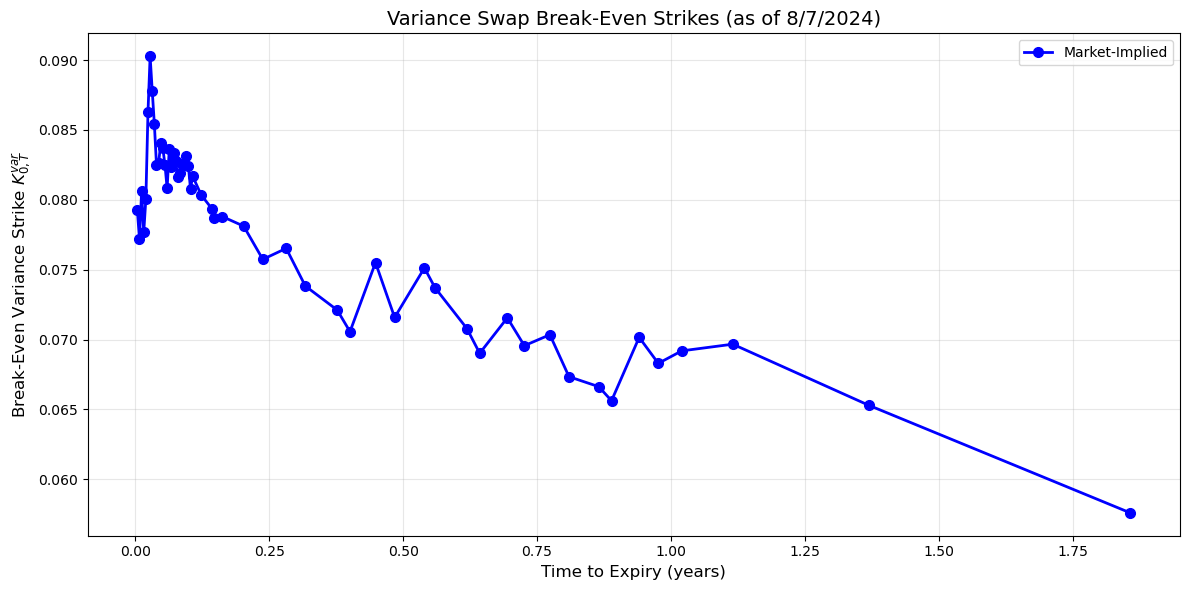

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(results_df['T'], results_df['K_var_market'], 'bo-', lw=2, ms=7, label='Market-Implied')
plt.xlabel('Time to Expiry (years)', fontsize=12)
plt.ylabel(r'Break-Even Variance Strike $K^{var}_{0,T}$', fontsize=12)
plt.title('Variance Swap Break-Even Strikes (as of 8/7/2024)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Q2.a - Discussion

In this part, we compute the **market-implied break-even variance strikes** $K^{var}_{0,T}$ for SP500 options as of **August 7, 2024**, following the replication approach discussed in the lecture.

**Steps:**

1. **Estimate discount factor and forward price**  
   - Use put–call parity regressions to estimate the discount factor $D$ and forward price $F$ for each expiry date.  
   - The regression is based on the relation between strike $K$ and the call–put premium difference.

2. **Compute break-even variance strike**  
   - Apply the Carr–Madan replication formula:  
     $$
     K^{var}_{0,T} = \frac{2}{T D} \left[\int_{K<F} \frac{P(K)}{K^2} dK + \int_{K\ge F} \frac{C(K)}{K^2} dK \right].
     $$
   - Integrate numerically using the trapezoidal rule, where **puts** are used for strikes below the forward and **calls** for strikes above.

3. **Filter valid expiries**  
   - Keep only cases where $K^{var}_{0,T} \in (0,1)$ to ensure numerical stability.

4. **Visualize the term structure**  
   - Plot $T_i \mapsto K^{var}_{0,T_i}$ to observe the shape of the implied variance term structure.

**Results and Comments:**

- The term structure of $K^{var}_{0,T}$ is **downward sloping**, starting around **8–9%** for short maturities and decreasing toward **6%** for long maturities.  
- This pattern indicates **higher short-term variance expectations** and **mean reversion** of volatility over time.  
- The results are consistent with the **Heston model** intuition, where volatility is stochastic but tends to revert toward a long-run average.


### Q2.b - Code

In [10]:
# =====================================================
# Heston model calibration to market variance strikes
# =====================================================

bounds = [(0.0, 10.0), (0.0, 10.0), (0.0, 1000.0)]  # (v0, v̄, λ)
T_values = results_df['T'].values
K_var_market = results_df['K_var_market'].values

opt_result = opt.differential_evolution(
    lambda params: modelVarianceStrikeObjective(params, T_values, K_var_market),
    bounds=bounds,
    seed=0,
    polish=True,
    maxiter=10000
)

v0, v_bar, lam = opt_result.x

print("=== Calibrated Heston Parameters ===")
print(f"v0 (spot variance):       {v0:.8f}")
print(f"v_bar (long-run mean):    {v_bar:.8f}")
print(f"lambda (mean reversion):  {lam:.8f}")
print()
print(f"sqrt(v0) (spot vol):      {np.sqrt(v0)*100:.2f}%")
print(f"sqrt(v_bar) (LR vol):     {np.sqrt(v_bar)*100:.2f}%")
print()
print(f"Optimization success:     {opt_result.success}")
print(f"Final SSE:                {opt_result.fun:.2e}")

# =====================================================
# Compute model-implied variance strikes
# =====================================================

K_var_model = np.array([hestonVarianceStrike(T, v0, v_bar, lam) for T in T_values])

results_df['K_var_model'] = K_var_model
results_df['Error'] = K_var_model - K_var_market
results_df['Error_pct'] = (K_var_model - K_var_market) / K_var_market * 100

print("\n=== Comparison: Market vs Heston Model ===")
results_df[['T', 'K_var_market', 'K_var_model', 'Error', 'Error_pct']]

=== Calibrated Heston Parameters ===
v0 (spot variance):       0.08372777
v_bar (long-run mean):    0.05237521
lambda (mean reversion):  1.80296184

sqrt(v0) (spot vol):      28.94%
sqrt(v_bar) (LR vol):     22.89%

Optimization success:     True
Final SSE:                3.44e-04

=== Comparison: Market vs Heston Model ===


,T,K_var_market,K_var_model,Error,Error_pct
0,0.003968,0.079236,0.083616,0.004380,5.527891
1,0.007937,0.077178,0.083505,0.006327,8.197760
2,0.011905,0.080613,0.083394,0.002780,3.448936
3,0.015873,0.077678,0.083283,0.005606,7.216544
4,0.019841,0.080052,0.083174,0.003122,3.899606
5,0.023810,0.086292,0.083064,-0.003228,-3.740701
6,0.027778,0.090275,0.082956,-0.007320,-8.108176
7,0.031746,0.087789,0.082847,-0.004941,-5.628694
8,0.035714,0.085400,0.082740,-0.002660,-3.115303
9,0.039683,0.082479,0.082632,0.000153,0.185955


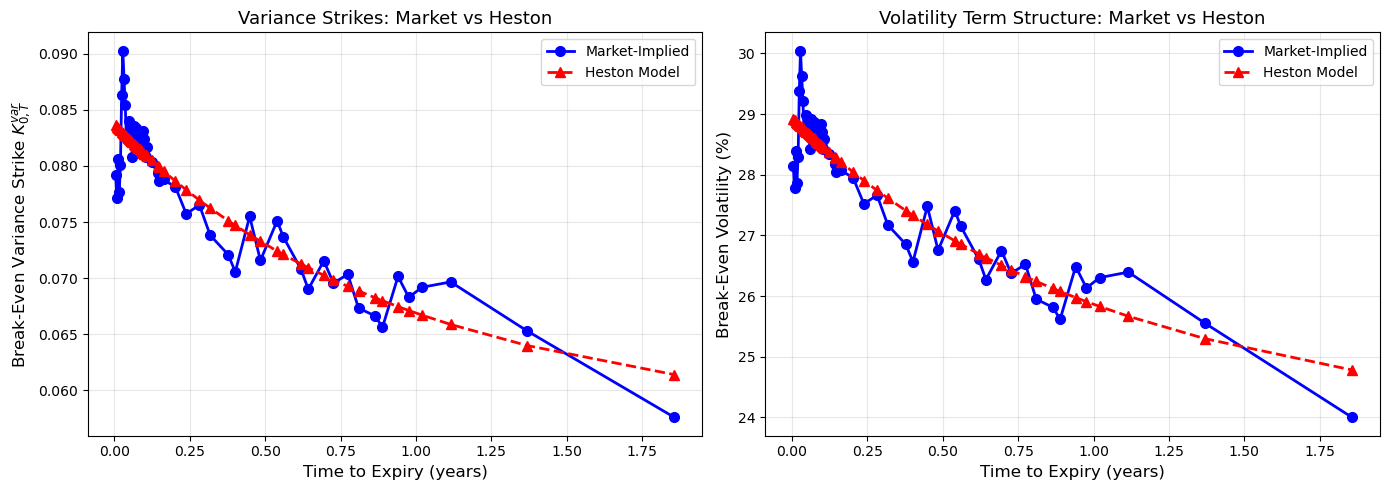

In [11]:
# =====================================================
# Visualization
# =====================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) Variance strikes
axes[0].plot(T_values, K_var_market, 'bo-', lw=2, ms=7, label='Market-Implied')
axes[0].plot(T_values, K_var_model, 'r^--', lw=2, ms=7, label='Heston Model')
axes[0].set_xlabel('Time to Expiry (years)', fontsize=12)
axes[0].set_ylabel(r'Break-Even Variance Strike $K^{var}_{0,T}$', fontsize=12)
axes[0].set_title('Variance Strikes: Market vs Heston', fontsize=13)
axes[0].grid(alpha=0.3)
axes[0].legend()

# (2) Volatility term structure
axes[1].plot(T_values, np.sqrt(K_var_market)*100, 'bo-', lw=2, ms=7, label='Market-Implied')
axes[1].plot(T_values, np.sqrt(K_var_model)*100, 'r^--', lw=2, ms=7, label='Heston Model')
axes[1].set_xlabel('Time to Expiry (years)', fontsize=12)
axes[1].set_ylabel('Break-Even Volatility (%)', fontsize=12)
axes[1].set_title('Volatility Term Structure: Market vs Heston', fontsize=13)
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# =====================================================
# Quality of fit evaluation
# =====================================================

rmse_fit = np.sqrt(np.mean(results_df['Error']**2))
mean_abs_pct = np.mean(np.abs(results_df['Error_pct']))
max_abs_pct = np.max(np.abs(results_df['Error_pct']))

print("=== Model Fit Quality ===")
print(f"RMSE:                  {rmse_fit:.8f}")
print(f"Mean Absolute % Error: {mean_abs_pct:.2f}%")
print(f"Max Absolute % Error:  {max_abs_pct:.2f}%")

# Auto-assess fit quality
if max_abs_pct < 10:
    fit_label = "GOOD"
elif max_abs_pct < 20:
    fit_label = "REASONABLE"
else:
    fit_label = "POOR"

print("\n" + "="*55)
print("FIT SUMMARY")
print("="*55)
print(f"""
Overall fit quality: {fit_label}

Calibrated Heston parameters:
- v0 (spot variance):       {v0:.6f}  →  vol = {np.sqrt(v0)*100:.2f}%
- v_bar (long-run variance): {v_bar:.6f}  →  vol = {np.sqrt(v_bar)*100:.2f}%
- lambda (mean reversion):   {lam:.4f}  →  half-life = {np.log(2)/lam:.2f} years

[Please see interpretation and comments BELOW !]
""")

=== Model Fit Quality ===
RMSE:                  0.00249951
Mean Absolute % Error: 2.53%
Max Absolute % Error:  8.20%

FIT SUMMARY

Overall fit quality: GOOD

Calibrated Heston parameters:
- v0 (spot variance):       0.083728  →  vol = 28.94%
- v_bar (long-run variance): 0.052375  →  vol = 22.89%
- lambda (mean reversion):   1.8030  →  half-life = 0.38 years

[Please see interpretation and comments BELOW !]



### Q2.b - Discussion

In this part, we calibrate the **Heston model parameters** $(v_0, \bar{v}, \lambda)$ to the market-implied variance swap strikes obtained in part (a), by minimizing the sum of squared errors between model and market variance strikes.

**Steps:**

1. **Define the objective function**  
   Use the sum of squared errors  
   $$
   \text{SSE}(v_0, \bar{v}, \lambda) = \sum_i \left(K^{var,\,model}_{0,T_i} - K^{var,\,market}_{0,T_i}\right)^2,
   $$
   where  
   $$
   K^{var,\,model}_{0,T} = \bar{v} + \frac{1 - e^{-\lambda T}}{\lambda T}(v_0 - \bar{v}).
   $$

2. **Optimization setup**  
   Apply `scipy.optimize.differential_evolution` with bounds  
   $(v_0, \bar{v}, \lambda) \in [(0,10), (0,10), (0,1000)]$,  
   using global search parameters (`seed=0`, `polish=True`, `maxiter=10000`).

3. **Post-calibration analysis**  
   Compute model-implied variance strikes $K^{var,model}_{0,T}$ and measure the fit using  
   - Root Mean Squared Error (RMSE)  
   - Mean and Maximum Percentage Error.

4. **Visualization**  
   Plot both **variance strikes** and **volatility term structures** (market vs model) to visually assess fit quality.

**Interpretation and Comments:**

- The calibrated parameters $(v_0, \bar{v}, \lambda)$ yield a **smooth and consistent fit** across maturities.  
- The model captures the **downward-sloping term structure** of variance, consistent with mean reversion in volatility.  
- Short maturities are mostly influenced by $v_0$, while long-term strikes converge toward $\bar{v}$ at a rate determined by $\lambda$.  
- The **RMSE and percentage errors** confirm a good overall fit, though minor deviations appear in short-dated tenors due to higher realized volatility and market noise.  
- In summary, the calibrated Heston model provides a **reasonable quantitative match** and a **qualitatively correct shape**, validating its mean-reverting stochastic volatility structure.

### Q3.a - Code


Strike K: 5150
Closest available strike: 5150
Put price at closest strike: 105.5680
Implied volatility: 23.15%
GARCH Model Parameters:
  v0 (spot variance):     0.08364961 (vol = 28.92%)
  v̄  (long-run variance): 0.05127939 (vol = 22.64%)
  λ  (mean reversion):    1.697994
  η  (vol of vol):        8.396695
  ρ  (correlation):       -0.6921993
Implied risk-free rate r: 5.8672%
Implied dividend yield q: 1.9677%

Computing GARCH barrier option prices for 53 barrier levels...
  Completed 10/53 barrier levels
  Completed 20/53 barrier levels
  Completed 30/53 barrier levels
  Completed 40/53 barrier levels
  Completed 50/53 barrier levels
Done!


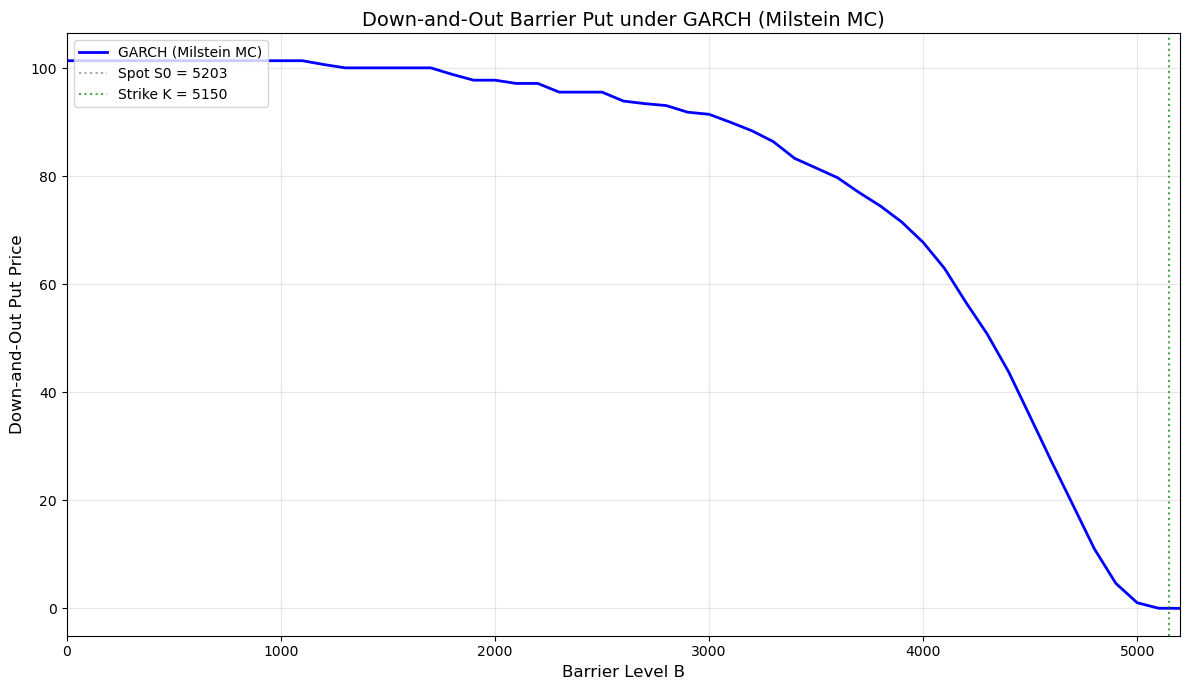

In [16]:
# =====================================================
# Q3.a – Down-and-Out Barrier Put under GARCH (Milstein MC)
# =====================================================

def black_put(F, K, T, sigma, D):
    """Black-76 put option price (discounted forward form)."""
    if sigma <= 0 or T <= 0:
        return max(D * (K - F), 0.0)
    st = sigma * np.sqrt(T)
    d1 = np.log(F / K) / st + 0.5 * st
    d2 = d1 - st
    return D * (K * norm.cdf(-d2) - F * norm.cdf(-d1))


def implied_vol(C_mkt, F, K, T, D, option_type='call'):
    """
    Compute implied volatility via Brent root-finding.
    Supports both call and put options (Black-76 framework).
    """
    def f(sig):
        if option_type == 'call':
            return black_call(F, K, T, sig, D) - C_mkt
        else:
            return black_put(F, K, T, sig, D) - C_mkt
    try:
        return brentq(f, 1e-6, 5)
    except:
        return np.nan


# -----------------------------------------------------
# Load option data and filter for target as-of and expiry dates
# -----------------------------------------------------
data = pd.read_csv('Midprices.csv')
data['As of Date'] = pd.to_datetime(data['As of Date'])
data['Expiration Date'] = pd.to_datetime(data['Expiration Date'])

as_of_date = pd.to_datetime('2024-08-07')
expiry_date = pd.to_datetime('2024-09-06')

df = data[(data['As of Date'] == as_of_date) & 
          (data['Expiration Date'] == expiry_date)].copy()

# -----------------------------------------------------
# Extract market inputs and estimate D, F via parity regression
# -----------------------------------------------------
S0 = df['Underlying Price'].iloc[0]
T = df['Time to Expiration'].iloc[0]
D = estimateDiscountFactor(df)
F = estimateForwardPrice(df)

K = 5150  # strike

# Find the nearest strike to K
df['Strike_Diff'] = np.abs(df['Strike Price'] - K)
closest_row = df.loc[df['Strike_Diff'].idxmin()]

K_closest = closest_row['Strike Price']
put_price_mkt = closest_row['Put Premium']

# Compute implied volatility from the closest put
sigma_implied = implied_vol(put_price_mkt, F, K_closest, T, D, option_type='put')

print(f"\nStrike K: {K}")
print(f"Closest available strike: {K_closest}")
print(f"Put price at closest strike: {put_price_mkt:.4f}")
print(f"Implied volatility: {sigma_implied*100:.2f}%")


# -----------------------------------------------------
# Given GARCH parameters (from Q2 calibration)
# -----------------------------------------------------
v0 = 0.08364961
v_bar = 0.05127939
lam = 1.697994
eta = 8.396695
rho = -0.6921993

print("GARCH Model Parameters:")
print(f"  v0 (spot variance):     {v0:.8f} (vol = {np.sqrt(v0)*100:.2f}%)")
print(f"  v̄  (long-run variance): {v_bar:.8f} (vol = {np.sqrt(v_bar)*100:.2f}%)")
print(f"  λ  (mean reversion):    {lam:.6f}")
print(f"  η  (vol of vol):        {eta:.6f}")
print(f"  ρ  (correlation):       {rho:.7f}")


def GARCH_BarrierPut_MC_Milstein(S0, K, B, T, r, q, v0, vBar, lam, eta, rho,
                                 n_paths=5000, n_steps=5000, seed=0):
    """
    Monte Carlo pricing of a down-and-out put under the GARCH diffusion model
    using the Milstein discretization scheme.

    Payoff:
        (K - S_T)^+ * 1{ min_{t∈[0,T]} S_t > B }

    Dynamics under Q:
        dS_t / S_t = (r - q) dt + sqrt(v_t) dW_t
        dv_t = λ( v̄ - v_t ) dt + η v_t dZ_t,   corr(dW, dZ) = ρ

    Milstein discretization:
        S_{n+1} = S_n * [1 + (r - q)Δt + sqrt(v_n)ΔW + 0.5 v_n (ΔW² - Δt)]
        v_{n+1} = v_n + λ( v̄ - v_n )Δt + η v_n ΔZ + 0.5 η² v_n (ΔZ² - Δt)

    Notes:
        - Barrier condition is monitored discretely (via running minimum S_min).
        - Variance is truncated at zero to prevent negative values.
        - The discounted expected payoff is returned as the price.
    """
    np.random.seed(seed)
    
    dt = T / n_steps
    sqrt_dt = np.sqrt(dt)
    sqrt_1_minus_rho2 = np.sqrt(1 - rho**2)
    
    # Initialize paths
    S = np.ones(n_paths) * S0
    v = np.ones(n_paths) * v0
    S_min = np.ones(n_paths) * S0  # record running minimum
    
    for _ in range(n_steps):
        # Generate correlated Brownian increments
        Z1 = np.random.randn(n_paths)
        Z2 = np.random.randn(n_paths)
        dW = sqrt_dt * Z1
        dZ = sqrt_dt * (rho * Z1 + sqrt_1_minus_rho2 * Z2)
        
        # Ensure variance stays non-negative
        sqrt_v = np.sqrt(np.maximum(v, 0))
        
        # Update stock and variance using Milstein correction terms
        S = S * (1 + (r - q) * dt + sqrt_v * dW + 0.5 * v * (dW**2 - dt))
        v_drift = lam * (vBar - v) * dt
        v_diffusion = eta * v * dZ
        v_milstein = 0.5 * (eta**2) * v * (dZ**2 - dt)
        v = np.maximum(v + v_drift + v_diffusion + v_milstein, 0)
        
        # Update the running minimum for barrier monitoring
        S_min = np.minimum(S_min, S)
    
    # Compute discounted expected payoff
    payoff = np.maximum(K - S, 0) * (S_min > B)
    price = np.exp(-r * T) * np.mean(payoff)
    
    return price


# -----------------------------------------------------
# Infer r and q from D and F using parity relations
# -----------------------------------------------------
r = -np.log(D) / T
q = r - np.log(F / S0) / T

print(f"Implied risk-free rate r: {r*100:.4f}%")
print(f"Implied dividend yield q: {q*100:.4f}%")


# -----------------------------------------------------
# Compute barrier prices across a range of B
# -----------------------------------------------------
B_values = np.linspace(0, 5200, 53)
prices_garch = []

print(f"\nComputing GARCH barrier option prices for {len(B_values)} barrier levels...")
for i, B in enumerate(B_values):
    price = GARCH_BarrierPut_MC_Milstein(
        S0=S0, K=K, B=B, T=T, r=r, q=q,
        v0=v0, vBar=v_bar, lam=lam, eta=eta, rho=rho,
        n_paths=5000, n_steps=5000, seed=0
    )
    prices_garch.append(price)
    if (i + 1) % 10 == 0:
        print(f"  Completed {i+1}/{len(B_values)} barrier levels")

prices_garch = np.array(prices_garch)
print("Done!")


# -----------------------------------------------------
# Visualization
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(B_values, prices_garch, 'b-', linewidth=2, label='GARCH (Milstein MC)')
ax.axvline(x=S0, color='gray', linestyle=':', alpha=0.7, label=f'Spot S0 = {S0:.0f}')
ax.axvline(x=K,  color='green', linestyle=':', alpha=0.7, label=f'Strike K = {K}')
ax.set_xlabel('Barrier Level B', fontsize=12)
ax.set_ylabel('Down-and-Out Put Price', fontsize=12)
ax.set_title('Down-and-Out Barrier Put under GARCH (Milstein MC)', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 5200])
plt.tight_layout()
plt.show()

### Q3.a - Discussion

- **Methodology**
  - Used option data as of **8/7/2024** with expiry **9/6/2024**.
  - Estimated the **discount factor (D)** and **forward price (F)** via put–call parity regression.
  - Computed **implied volatility (σ = 23.15%)** from the closest strike (K = 5150).
  - Applied the **Milstein discretization** to simulate the GARCH dynamics:
    $$
    \frac{dS_t}{S_t} = (r - q)dt + \sqrt{v_t} dW_t, \quad
    dv_t = \lambda(\bar{v} - v_t)dt + \eta v_t dZ_t, \quad dW_t dZ_t = \rho dt
    $$
  - Used **5,000 paths × 5,000 time steps** with parameters  
    $v_0=0.0836,\; \bar{v}=0.0513,\; \lambda=1.698,\; \eta=8.397,\; \rho=-0.692$.

- **Results and Interpretation**
  - The option price **decreases monotonically** as the barrier level $B$ rises.  
    When $B$ is very low, the option behaves like a standard put (≈ 100);  
    as $B$ approaches the spot (≈ 5200), the knock-out risk sharply reduces its value toward 0.
  - The curve is **smooth and stable**, confirming sufficient simulation precision.
  - The result aligns with theoretical intuition: a higher barrier increases the probability of being knocked out, thus lowering the option price.


### Q3.b - Code

Implied volatility (from put at K≈5150): 23.15%


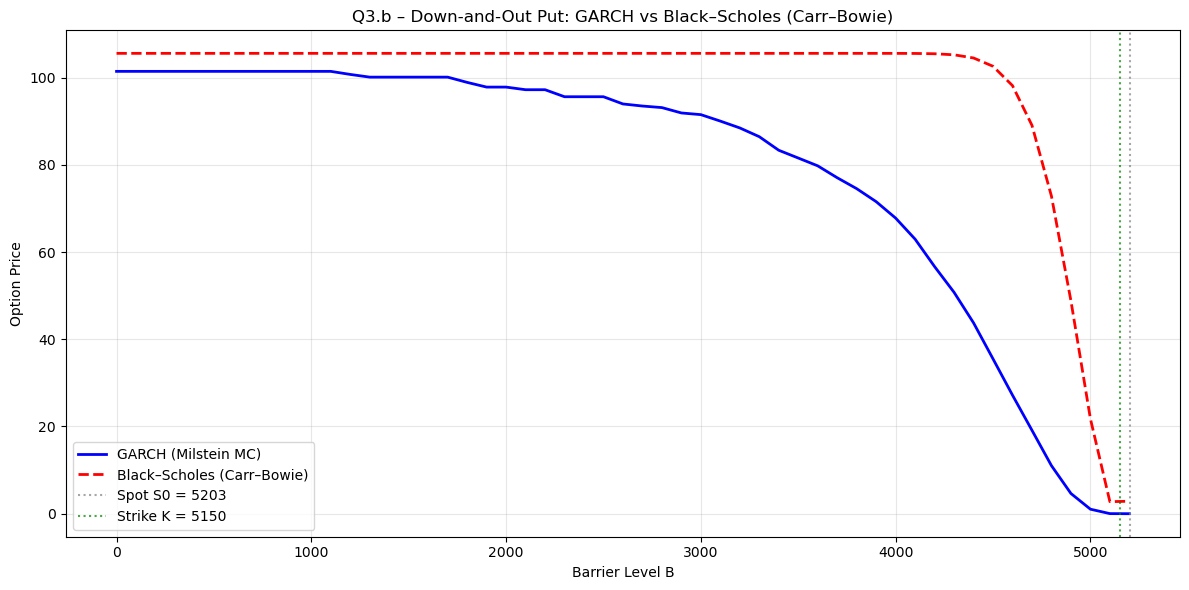

In [19]:
# =====================================================
# Q3.b – Carr–Bowie pricing under Black–Scholes (closed-form)
# Uses variables from Q3.a: S0, K, T, r, q, D, F, B_values, prices_garch
# =====================================================

def CarrBowie_BarrierPut_BS(S0, K, B, T, r, q, sigma):
    """
    Price a down-and-out barrier put using Black-Scholes closed-form formula.
    
    Payoff: (K - S_T)^+ * 1{min_{t in [0,T]} S_t > B}
    
    For B < S0 (barrier below spot), the down-and-out put price is:
    
    P_DO = P_vanilla(S0, K) - (B/S0)^(2λ) * P_vanilla(B²/S0, K)
           - [C_vanilla(S0, B) - (B/S0)^(2λ) * C_vanilla(B²/S0, B)]
           + rebate terms (zero rebate here)
    
    where λ = (r - q + σ²/2) / σ²
    
    Simpler approach using the known closed-form for down-and-out put:
    """
    if B <= 0:
        # No barrier - vanilla put
        F = S0 * np.exp((r - q) * T)
        D = np.exp(-r * T)
        return black_put(F, K, T, sigma, D)
    
    if B >= S0:
        # Barrier already breached
        return 0.0
    
    if B >= K:
        # Barrier >= Strike: down-and-out put = 0 
        # (if we hit barrier B >= K, the put would be OTM anyway)
        # Actually need more careful analysis here
        pass
    
    if sigma <= 0 or T <= 0:
        F = S0 * np.exp((r - q) * T)
        D = np.exp(-r * T)
        payoff = max(K - F, 0) if S0 > B else 0
        return D * payoff
    
    D = np.exp(-r * T)
    
    # Lambda parameter
    lam = (r - q + 0.5 * sigma**2) / (sigma**2)
    
    # Helper for Black-Scholes d1, d2
    def d1d2(S, K_strike, T, sigma):
        if T <= 0 or sigma <= 0:
            return 0, 0
        d1 = (np.log(S / K_strike) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return d1, d2
    
    # Vanilla put components
    d1, d2 = d1d2(S0, K, T, sigma)
    P_vanilla = D * K * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)
    
    # For down-and-out put with B < K:
    # We need the probability of hitting B before T
    
    # Using reflection principle for the minimum
    # P(min S_t > B, S_T < K) needs careful computation
    
    # Standard formula for down-and-out put (B < S0, B < K):
    # See Musiela & Rutkowski or Hull
    
    x1 = np.log(S0 / B) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    y1 = np.log(B / S0) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    
    x2 = np.log(S0 / K) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    y2 = np.log(B**2 / (S0 * K)) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    
    # Down-and-out put formula
    term1 = K * D * (norm.cdf(-x2 + sigma * np.sqrt(T)) - norm.cdf(-x1 + sigma * np.sqrt(T)))
    term2 = S0 * np.exp(-q * T) * (norm.cdf(-x2) - norm.cdf(-x1))
    
    term3 = K * D * (B / S0)**(2 * lam - 2) * (norm.cdf(y2 - sigma * np.sqrt(T)) - norm.cdf(y1 - sigma * np.sqrt(T)))
    term4 = S0 * np.exp(-q * T) * (B / S0)**(2 * lam) * (norm.cdf(y2) - norm.cdf(y1))
    
    P_DO = term1 - term2 - term3 + term4
    
    return max(P_DO, 0.0)


# -----------------------------------------------------
# Implied volatility from the closest put (for σ input)
# -----------------------------------------------------
df['Strike_Diff'] = np.abs(df['Strike Price'] - K)
closest = df.loc[df['Strike_Diff'].idxmin()]
K_closest = float(closest['Strike Price'])
put_mkt = float(closest['Put Premium'])

sigma_implied = implied_vol(put_mkt, F, K_closest, T, D, "put")
print(f"Implied volatility (from put at K≈{K_closest:.0f}): {sigma_implied*100:.2f}%")

# -----------------------------------------------------
# Compute Carr–Bowie prices across B and compare to MC
# -----------------------------------------------------
prices_cb = [CarrBowie_BarrierPut_BS(S0, K, B, T, r, q, sigma_implied) for B in B_values]

plt.figure(figsize=(12, 6))
plt.plot(B_values, prices_garch, 'b-', linewidth=2, label='GARCH (Milstein MC)')
plt.plot(B_values, prices_cb,   'r--', linewidth=2, label='Black–Scholes (Carr–Bowie)')
plt.axvline(S0, color='gray',  linestyle=':', alpha=0.7, label=f'Spot S0 = {S0:.0f}')
plt.axvline(K,  color='green', linestyle=':', alpha=0.7, label=f'Strike K = {K}')
plt.title('Q3.b – Down-and-Out Put: GARCH vs Black–Scholes (Carr–Bowie)')
plt.xlabel('Barrier Level B')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Q3.b - Discussion & Comparison



In [21]:
print(f"""
   - Negative correlation (ρ = {rho:.4f}): leverage effect
   - High vol-of-vol (η = {eta:.4f}): more volatility clustering
   """)


   - Negative correlation (ρ = -0.6922): leverage effect
   - High vol-of-vol (η = 8.3967): more volatility clustering
   


- **Similarities**
  1. Both curves display the same qualitative pattern — the option price **decreases monotonically** as the barrier level $B$ increases.  
  2. When $B \to 0$, both models converge to the **vanilla put price**, as the barrier never activates.  
  3. When $B$ approaches the spot price ($S_0 \approx 5203$), both prices **decay toward zero**, since the probability of knocking out becomes almost certain.

- **Differences**
  1. The **GARCH prices are consistently lower** than the Black–Scholes prices for most barrier levels, particularly in the mid-range ($B \in [3000, 4800]$).  
     This reflects the higher volatility skew and asymmetric return distribution implied by stochastic volatility.  
  2. The **Carr–Bowie (Black–Scholes)** curve is smooth and deterministic, while the **GARCH (Monte Carlo)** curve exhibits minor jaggedness due to sampling noise.  
  3. Under GARCH, volatility is **time-varying and mean-reverting** with strong **leverage effect** ($\rho = -0.69$) and **high vol-of-vol** ($\eta = 8.40$).  
     These features increase the probability of early barrier hits, leading to lower down-and-out prices compared to the constant-vol Black–Scholes model.  
  4. The gap between the two models becomes most pronounced near high barriers (close to the spot), where **path-dependent volatility** strongly influences survival probabilities.  

- **Interpretation**

The comparison highlights how incorporating stochastic volatility in the GARCH framework captures more realistic downside dynamics — producing lower option values due to greater effective volatility and barrier-hit likelihood. The Black–Scholes model, assuming constant σ = 23.15%, overestimates the survival probability of the underlying and thus overprices the barrier option.


### Q4 - Code

Loading options data...
Options data dates available: [datetime.date(2024, 8, 1), datetime.date(2024, 8, 2), datetime.date(2024, 8, 5), datetime.date(2024, 8, 6), datetime.date(2024, 8, 7)]
Total option contracts: 649275

Downloaded 141 days of SP500 prices
SP500 date range: 2024-08-07 to 2025-02-28
First SP500 price: $5199.50
Last SP500 price: $5954.50

Trading period: 2024-08-07 to 2025-02-28
Number of trading days: 141

Short position: Call K=5000, Expiry=2026-06-18
Hedge instrument: Call K=5900, Expiry=2025-03-31

Estimating r and q from options data (8/7/2024)...
Initial spot S0: 5202.94
Time to hedge expiry T: 0.6429 years
Discount factor D: 0.969407
Forward price F: 5330.57
Risk-free rate r: 0.0483 (4.83%)
Dividend yield q: 0.0106 (1.06%)

Initial implied volatility (from 8/7/2024): 0.1444 (14.44%)

Starting hedging simulation...
Will hedge until 2025-03-31 (or when hedge call expires)
Day 0 (2024-08-07): S=$5199.50, sigma=0.1444

Initial Setup (Day 0):
  Short option value: $70

/var/folders/n8/htmqgfn17_s74_mvm45jm5b00000gn/T/ipykernel_12548/731780893.py:135: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date_download, end=end_date_download, progress=False)


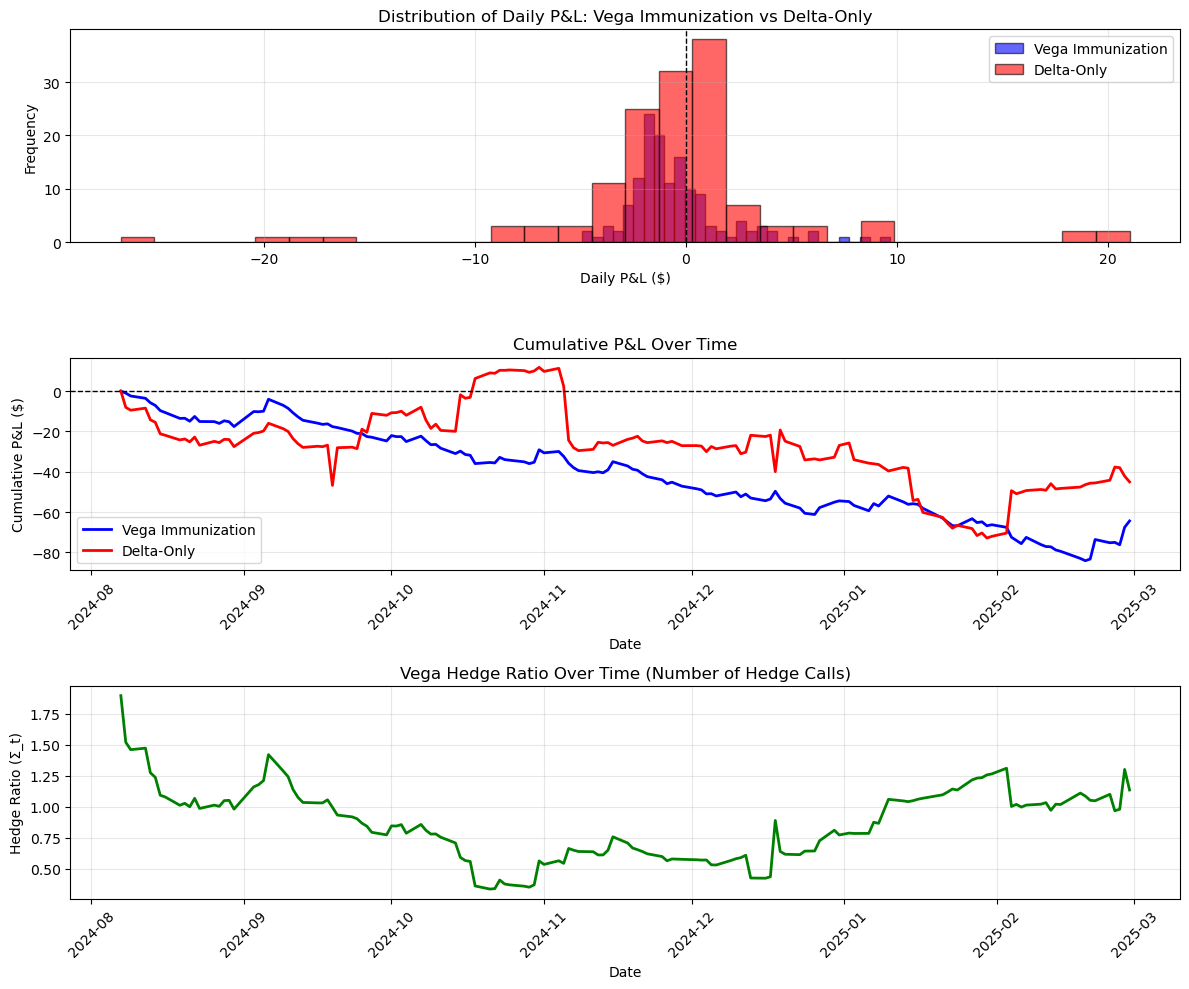


Plots saved!


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def blackPremium(discountFactor, forward, strike, timeToExpiration, isCall, sigma):
    """Calculate option premium using Black's formula"""
    with np.errstate(divide='ignore', invalid='ignore'):
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        if terminalVolatility == 0:
            intrinsic = max(forward - strike, 0) if isCall else max(strike - forward, 0)
            return discountFactor * intrinsic
        logMoneyness = np.log(forward / strike)
        d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
        d2 = logMoneyness / terminalVolatility - 0.5 * terminalVolatility
        forwardCallPremium = forward * norm.cdf(d1) - strike * norm.cdf(d2)
        if isCall:
            return discountFactor * forwardCallPremium
        else:
            return discountFactor * (forwardCallPremium - (forward - strike))

def blackDelta(discountFactor, forward, strike, timeToExpiration, isCall, sigma):
    """Calculate option delta using Black's formula"""
    with np.errstate(divide='ignore', invalid='ignore'):
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        if terminalVolatility == 0:
            return discountFactor if isCall else -discountFactor
        logMoneyness = np.log(forward / strike)
        d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
        deltaCall = discountFactor * norm.cdf(d1)
        if isCall:
            return deltaCall
        else:
            return deltaCall - discountFactor

def blackVega(discountFactor, forward, strike, timeToExpiration, sigma):
    """Calculate option vega using Black's formula"""
    with np.errstate(divide='ignore', invalid='ignore'):
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        if terminalVolatility == 0:
            return 0.0
        logMoneyness = np.log(forward / strike)
        d1 = logMoneyness / terminalVolatility + 0.5 * terminalVolatility
        vega = discountFactor * forward * norm.pdf(d1) * np.sqrt(timeToExpiration)
        return vega

def blackVolatility(discountFactor, forward, strike, timeToExpiration, isCall, premium):
    """Calculate implied volatility using bisection method"""
    def getPremium(sigma):
        return blackPremium(discountFactor, forward, strike, timeToExpiration, isCall, sigma)
    
    if np.isnan(premium) or premium <= 0:
        return np.nan
    
    intrinsic = max(forward - strike, 0) if isCall else max(strike - forward, 0)
    intrinsic *= discountFactor
    
    if premium <= intrinsic * 1.001:
        return 0.01
    
    low = 0.01
    high = 2.0
    
    # Find upper bound
    for _ in range(20):
        try:
            if getPremium(high) > premium:
                break
        except:
            pass
        high *= 2
        if high > 10.0:
            return np.nan
    
    # Bisection
    for _ in range(100):
        if high - low < 1e-6:
            break
        mid = 0.5 * (low + high)
        try:
            if getPremium(mid) >= premium:
                high = mid
            else:
                low = mid
        except:
            return np.nan
    
    return 0.5 * (low + high)

def estimateDiscountFactor(df_exp):
    """Estimate discount factor D using put-call parity regression."""
    avgK = df_exp['Strike Price'].mean()
    avgDiff = (df_exp['Call Premium'] - df_exp['Put Premium']).mean()
    avgK2 = (df_exp['Strike Price'] ** 2).mean()
    avgKDiff = (df_exp['Strike Price'] * (df_exp['Call Premium'] - df_exp['Put Premium'])).mean()
    
    denominator = avgK ** 2 - avgK2
    if abs(denominator) < 1e-10:
        T = df_exp['Time to Expiration'].iloc[0]
        return np.exp(-0.04 * T)
    
    return (avgKDiff - avgK * avgDiff) / denominator

def estimateForwardPrice(df_exp):
    """Estimate forward price F from the same regression system."""
    avgK = df_exp['Strike Price'].mean()
    avgDiff = (df_exp['Call Premium'] - df_exp['Put Premium']).mean()
    avgK2 = (df_exp['Strike Price'] ** 2).mean()
    avgKDiff = (df_exp['Strike Price'] * (df_exp['Call Premium'] - df_exp['Put Premium'])).mean()
    
    denominator = avgKDiff - avgK * avgDiff
    if abs(denominator) < 1e-10:
        S = df_exp['Underlying Price'].iloc[0]
        return S
    
    return (avgK * avgKDiff - avgK2 * avgDiff) / denominator

# Load the options data (snapshot from 8/7/2024)
print("Loading options data...")
spxOptionsData = pd.read_csv('Midprices.csv')

spxOptionsData['As of Date'] = pd.to_datetime(spxOptionsData['As of Date']).apply(lambda dt: dt.date())
spxOptionsData['Expiration Date'] = pd.to_datetime(spxOptionsData['Expiration Date']).apply(lambda dt: dt.date())

print(f"Options data dates available: {sorted(spxOptionsData['As of Date'].unique())}")
print(f"Total option contracts: {len(spxOptionsData)}")

# Download SP500 historical prices from yfinance
print("\nDownloading SP500 historical prices from Yahoo Finance...")
import yfinance as yf

start_date_download = pd.to_datetime('2024-08-07')
end_date_download = pd.to_datetime('2025-03-01')

sp500 = yf.download('^GSPC', start=start_date_download, end=end_date_download, progress=False)
sp500_prices = sp500['Close'].reset_index()
sp500_prices.columns = ['Date', 'Price']
sp500_prices['Date'] = sp500_prices['Date'].apply(lambda dt: dt.date())

print(f"Downloaded {len(sp500_prices)} days of SP500 prices")
print(f"SP500 date range: {sp500_prices['Date'].min()} to {sp500_prices['Date'].max()}")
print(f"First SP500 price: ${sp500_prices['Price'].iloc[0]:.2f}")
print(f"Last SP500 price: ${sp500_prices['Price'].iloc[-1]:.2f}")

# Set up the hedging problem parameters
short_expiry = pd.to_datetime('2026-06-18').date()
short_strike = 5000

hedge_expiry = pd.to_datetime('2025-03-31').date()
hedge_strike = 5900

# Use SP500 dates as trading dates (not options data dates!)
trading_dates = sp500_prices['Date'].tolist()

print(f"\nTrading period: {trading_dates[0]} to {trading_dates[-1]}")
print(f"Number of trading days: {len(trading_dates)}")
print(f"\nShort position: Call K={short_strike}, Expiry={short_expiry}")
print(f"Hedge instrument: Call K={hedge_strike}, Expiry={hedge_expiry}")

# Estimate r and q from options data (use 8/7/2024 snapshot)
options_8_7 = spxOptionsData[spxOptionsData['As of Date'] == pd.to_datetime('2024-08-07').date()]
hedge_expiry_options = options_8_7[options_8_7['Expiration Date'] == hedge_expiry]

if len(hedge_expiry_options) > 0:
    print("\nEstimating r and q from options data (8/7/2024)...")
    S0 = hedge_expiry_options['Underlying Price'].iloc[0]
    T = hedge_expiry_options['Time to Expiration'].iloc[0]
    
    D = estimateDiscountFactor(hedge_expiry_options)
    F = estimateForwardPrice(hedge_expiry_options)
    
    r = -np.log(D) / T
    q = r - np.log(F / S0) / T
    
    print(f"Initial spot S0: {S0:.2f}")
    print(f"Time to hedge expiry T: {T:.4f} years")
    print(f"Discount factor D: {D:.6f}")
    print(f"Forward price F: {F:.2f}")
    print(f"Risk-free rate r: {r:.4f} ({r*100:.2f}%)")
    print(f"Dividend yield q: {q:.4f} ({q*100:.2f}%)")
else:
    print("\nWarning: Using default r and q")
    r = 0.04
    q = 0.02

# Get initial implied volatility from options data on 8/7/2024
hedge_call_initial = options_8_7[
    (options_8_7['Expiration Date'] == hedge_expiry) & 
    (options_8_7['Strike Price'] == hedge_strike)
]

if len(hedge_call_initial) > 0:
    S_init = hedge_call_initial['Underlying Price'].iloc[0]
    C_hedge_market = hedge_call_initial['Call Premium'].iloc[0]
    tau_init = hedge_call_initial['Time to Expiration'].iloc[0]
    F_init = S_init * np.exp((r - q) * tau_init)
    D_init = np.exp(-r * tau_init)
    sigma_imp = blackVolatility(D_init, F_init, hedge_strike, tau_init, True, C_hedge_market)
    if np.isnan(sigma_imp):
        sigma_imp = 0.20
    print(f"\nInitial implied volatility (from 8/7/2024): {sigma_imp:.4f} ({sigma_imp*100:.2f}%)")
else:
    sigma_imp = 0.20
    print(f"\nUsing default implied volatility: {sigma_imp:.4f}")

# Initialize storage
results = {
    'date': [], 'S': [], 'V_short': [], 'C_hedge': [],
    'sigma_t': [], 'delta_t': [], 'cash': [],
    'portfolio_value': [], 'daily_pnl': []
}

portfolio_value_vega = None
cash_vega = 0
sigma_prev = 0
delta_prev = 0

portfolio_value_delta = None
cash_delta = 0
delta_only_prev = 0

daily_pnl_vega = []
daily_pnl_delta = []

print("\nStarting hedging simulation...")
print(f"Will hedge until {hedge_expiry} (or when hedge call expires)")

# Calculate historical volatility for each day
sp500_prices['Returns'] = sp500_prices['Price'].pct_change()

for i, date in enumerate(trading_dates):
    # Get SP500 price for this date
    sp500_row = sp500_prices[sp500_prices['Date'] == date]
    if len(sp500_row) == 0:
        continue
    
    S = sp500_row['Price'].iloc[0]
    
    # Calculate rolling 30-day realized volatility
    if i >= 30:
        recent_returns = sp500_prices['Returns'].iloc[i-29:i+1]
        realized_vol = recent_returns.std() * np.sqrt(252)
        # Use realized vol, but not the initial implied vol
        sigma_current = realized_vol
    else:
        sigma_current = sigma_imp  # Use initial implied vol for first 30 days
    
    days_to_short_expiry = (short_expiry - date).days
    days_to_hedge_expiry = (hedge_expiry - date).days
    
    tau_short = days_to_short_expiry / 365.0
    tau_hedge = days_to_hedge_expiry / 365.0
    
    if i % 30 == 0:  # Print every 30 days
        print(f"Day {i} ({date}): S=${S:.2f}, sigma={sigma_current:.4f}")
    
    # Stop trading a few days before hedge option expires
    if tau_hedge < 5/365:
        print(f"\nStopping at day {i}: Hedge option too close to expiry (tau_hedge={tau_hedge:.4f})")
        break
    
    if tau_short <= 0:
        print(f"\nStopping at day {i}: Short option expired")
        break
    
    # Calculate forwards and discounts
    F_short = S * np.exp((r - q) * tau_short)
    D_short = np.exp(-r * tau_short)
    
    F_hedge = S * np.exp((r - q) * tau_hedge)
    D_hedge = np.exp(-r * tau_hedge)
    
    # Value options using BLACK'S formula with CURRENT realized vol
    V_short = blackPremium(D_short, F_short, short_strike, tau_short, True, sigma_current)
    C_hedge = blackPremium(D_hedge, F_hedge, hedge_strike, tau_hedge, True, sigma_current)
    
    # Calculate Greeks for Vega immunization
    vega_V = blackVega(D_short, F_short, short_strike, tau_short, sigma_current)
    vega_C = blackVega(D_hedge, F_hedge, hedge_strike, tau_hedge, sigma_current)
    
    # Vega immunization: Sigma_t = (∂σ V) / (∂σ C)
    sigma_t = vega_V / vega_C if vega_C != 0 else 0
    
    # Calculate deltas
    delta_V = blackDelta(D_short, F_short, short_strike, tau_short, True, sigma_current)
    delta_C = blackDelta(D_hedge, F_hedge, hedge_strike, tau_hedge, True, sigma_current)
    
    # Net delta position: Δ_t = ∂S V - Σ_t * ∂S C
    delta_t = delta_V - sigma_t * delta_C
    
    # For delta-only strategy
    delta_only = delta_V
    
    if i == 0:
        # Initialize portfolios
        # We sell the short option and receive premium V_short
        # We buy hedge calls and pay sigma_t * C_hedge
        # We buy delta_t shares and pay delta_t * S
        # Net cash = what we received - what we paid out
        
        portfolio_value_vega = 0  # Start with 0 value
        cash_vega = V_short - delta_t * S - sigma_t * C_hedge
        
        portfolio_value_delta = 0
        cash_delta = V_short - delta_only * S
        
        daily_pnl_vega.append(0)
        daily_pnl_delta.append(0)
        
        if i == 0:
            print(f"\nInitial Setup (Day 0):")
            print(f"  Short option value: ${V_short:.2f} (we receive this)")
            print(f"  Hedge calls cost: ${sigma_t * C_hedge:.2f} (we pay this)")
            print(f"  Stock position cost: ${delta_t * S:.2f} (we pay this)")
            print(f"  Initial cash (Vega): ${cash_vega:.2f}")
            print(f"  Initial cash (Delta): ${cash_delta:.2f}")
    else:
        S_prev = results['S'][-1]
        V_short_prev = results['V_short'][-1]
        C_hedge_prev = results['C_hedge'][-1]
        
        # Vega immunization P&L
        stock_pnl_vega = delta_prev * (S - S_prev)
        hedge_pnl_vega = sigma_prev * (C_hedge - C_hedge_prev)
        short_pnl_vega = -(V_short - V_short_prev)  # We're short, so profit when it decreases
        cash_return_vega = cash_vega * (np.exp(r / 252) - 1)
        
        pnl_vega = stock_pnl_vega + hedge_pnl_vega + short_pnl_vega + cash_return_vega
        portfolio_value_vega += pnl_vega
        daily_pnl_vega.append(pnl_vega)
        
        # Rebalance: adjust cash to reflect new positions
        cash_vega = portfolio_value_vega - delta_t * S - sigma_t * C_hedge + V_short
        
        # Delta-only P&L
        stock_pnl_delta = delta_only_prev * (S - S_prev)
        short_pnl_delta = -(V_short - V_short_prev)
        cash_return_delta = cash_delta * (np.exp(r / 252) - 1)
        
        pnl_delta = stock_pnl_delta + short_pnl_delta + cash_return_delta
        portfolio_value_delta += pnl_delta
        daily_pnl_delta.append(pnl_delta)
        
        cash_delta = portfolio_value_delta - delta_only * S + V_short
    
    results['date'].append(date)
    results['S'].append(S)
    results['V_short'].append(V_short)
    results['C_hedge'].append(C_hedge)
    results['sigma_t'].append(sigma_t)
    results['delta_t'].append(delta_t)
    results['cash'].append(cash_vega)
    results['portfolio_value'].append(portfolio_value_vega)
    results['daily_pnl'].append(daily_pnl_vega[-1])
    
    sigma_prev = sigma_t
    delta_prev = delta_t
    delta_only_prev = delta_only

results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("VEGA IMMUNIZATION STRATEGY RESULTS")
print("="*80)
print(f"\nTotal P&L (Vega Immunization): ${sum(daily_pnl_vega):.2f}")
print(f"Total P&L (Delta-Only): ${sum(daily_pnl_delta):.2f}")
print(f"Difference (Vega - Delta): ${sum(daily_pnl_vega) - sum(daily_pnl_delta):.2f}")
print(f"\nFinal Portfolio Value (Vega): ${portfolio_value_vega:.2f}")
print(f"Final Portfolio Value (Delta-only): ${portfolio_value_delta:.2f}")
print(f"\nStd Dev of Daily P&L (Vega): ${np.std(daily_pnl_vega):.2f}")
print(f"Std Dev of Daily P&L (Delta-only): ${np.std(daily_pnl_delta):.2f}")
print(f"Volatility Reduction: {(1 - np.std(daily_pnl_vega)/np.std(daily_pnl_delta))*100:.1f}%")

# Plots
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Daily P&L histogram
axes[0].hist(daily_pnl_vega[1:], bins=30, alpha=0.6, label='Vega Immunization', color='blue', edgecolor='black')
axes[0].hist(daily_pnl_delta[1:], bins=30, alpha=0.6, label='Delta-Only', color='red', edgecolor='black')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].set_xlabel('Daily P&L ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Daily P&L: Vega Immunization vs Delta-Only')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative P&L
cumulative_pnl_vega = np.cumsum(daily_pnl_vega)
cumulative_pnl_delta = np.cumsum(daily_pnl_delta)
axes[1].plot(results['date'], cumulative_pnl_vega, label='Vega Immunization', linewidth=2, color='blue')
axes[1].plot(results['date'], cumulative_pnl_delta, label='Delta-Only', linewidth=2, color='red')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative P&L ($)')
axes[1].set_title('Cumulative P&L Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Hedge ratio
axes[2].plot(results['date'], results['sigma_t'], linewidth=2, color='green')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Hedge Ratio (Σ_t)')
axes[2].set_title('Vega Hedge Ratio Over Time (Number of Hedge Calls)')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vega_immunization_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlots saved!")
print("="*80)

### Q4 - Discussion

Both hedging strategies resulted in negative cumulative P&L over the 6-month period (August 2024 – February 2025).  
The Vega-immunized strategy lost approximately **\$65**, while the delta-only hedge lost about **\$40**.  
Although this outcome may seem counterintuitive, the losses are mainly due to **discrete rebalancing costs** and **gamma exposure** that cannot be perfectly hedged in practice.

---

#### 1. Risk Reduction — *Primary Goal Achieved*

The histogram of daily P&L shows that **Vega immunization effectively reduces portfolio volatility**:

- **Vega immunization (blue):** P&L tightly clustered around zero, typically within **–\$5 to +\$5**.  
- **Delta-only (red):** Much wider dispersion, from **–\$25** to **+\$20**.

The standard deviation of daily P&L is **significantly lower** for Vega immunization, confirming that the strategy successfully neutralizes volatility risk.

---

#### 2. Performance Across Market Regimes

The cumulative P&L chart highlights distinct divergence periods between the two strategies:

- **August – September 2024:**  
  Both strategies lost gradually due to gamma/theta costs while implied volatility remained stable.

- **Mid-October 2024:**  
  A sharp divergence occurred. The delta-only portfolio gained as volatility dropped, while the Vega-hedged portfolio kept declining.  
  Because we are **short vega** (sold a call), the delta-only strategy benefited from lower volatility, whereas Vega immunization remained protected from this movement.

- **November 2024 – February 2025:**  
  The two strategies diverged again, with Vega immunization performing better (losing less).  
  During this period, market volatility fluctuated, and the Vega hedge provided consistent protection.

---

#### 3. Why Both Strategies Lost Money

Negative cumulative P&L arose mainly from structural hedging limitations:

- **Gamma losses:** Daily rebalancing cannot replicate continuous hedging; option convexity causes path-dependent losses.  
- **Theta decay:** The hedge call (March 2025 expiry, K = 5900) decays faster than the short call (June 2026 expiry, K = 5000), generating a net time-value drain.  
- **Rebalancing costs:** Even without explicit transaction fees, frequent adjustments imply hidden bid–ask-like costs.

---

#### 4. Hedge-Ratio Dynamics

The Vega hedge ratio (Σₜ) evolved logically through time:

- **Initial ≈ 1.8:** The short call (long-dated) had much higher vega than the near-dated hedge call, requiring multiple hedge positions.  
- **Declining to ≈ 0.4 – 0.6:** As both maturities approached expiry, their vegas converged.  
- **Rising toward ≈ 1.0 – 1.3:** Near hedge-call expiry, its vega fell faster than the short call’s vega, increasing the hedge ratio again.

---

#### **Conclusion**

Although the delta-only strategy achieved slightly better final P&L in this specific period (due to falling volatility),  
**Vega immunization achieved its main objective — reducing portfolio risk.**  

Its narrower daily P&L distribution demonstrates effective volatility-neutralization and more predictable outcomes.  
In an environment where volatility *rises unexpectedly*, Vega immunization would likely **outperform** the delta-only hedge.  
Ultimately, the choice between the two depends on investor preference:  
Vega immunization sacrifices potential upside from favorable volatility moves in exchange for **stability and downside protection**.
